In [1]:
import pandas as pd
df = pd.read_excel(r'C:\Users\Edu\Desktop\Definitivo.xlsx', 'ch_ln3', header = 1).set_index('Date')
df

,Ex_rate,WTI,FCR,CPI,M1,r
Date,,,,,,
1994-10-10,NaN,NaN,NaN,NaN,NaN,NaN
1994-11-10,NaN,NaN,NaN,NaN,NaN,NaN
1994-12-10,NaN,NaN,NaN,NaN,NaN,NaN
1995-01-10,NaN,NaN,NaN,NaN,NaN,NaN
1995-02-10,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2020-05-10,-19.348756,-65.670429,2.492865,-1.757812,5.625369,0.0
2020-06-10,-19.840640,-53.535747,1.116478,-1.365653,4.102599,0.0
2020-07-10,-7.752478,-65.268960,3.737352,-0.775886,5.636824,0.0


In [2]:
df = df.dropna()

df

,Ex_rate,WTI,FCR,CPI,M1,r
Date,,,,,,
2002-12-10,-0.033824,-60.651449,-12.775041,5.972168,16.881143,-9.684983
2003-01-10,-0.022951,-41.725177,-9.417767,7.193074,17.838460,-9.684983
2003-02-10,-0.020539,-16.507781,-6.070815,-0.497761,17.252291,19.369965
2003-03-10,-0.004831,16.760988,-7.331691,5.896277,18.328845,19.369965
2003-04-10,-0.037448,46.391634,-9.971627,9.983061,16.519013,19.369965
...,...,...,...,...,...,...
2020-04-10,-18.179171,-64.743975,4.907727,-0.001946,6.575951,0.000000
2020-05-10,-19.348756,-65.670429,2.492865,-1.757812,5.625369,0.000000
2020-06-10,-19.840640,-53.535747,1.116478,-1.365653,4.102599,0.000000


In [3]:
nobs = 4
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)

(209, 6)
(4, 6)


In [5]:
from statsmodels.tsa.stattools import adfuller
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 
          
# ADF Test on each column
        
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Ex_rate" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.1687
 No. Lags Chosen       = 15
 Critical value 1%     = -3.465
 Critical value 5%     = -2.877
 Critical value 10%    = -2.575
 => P-Value = 0.0219. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "WTI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.3554
 No. Lags Chosen       = 12
 Critical value 1%     = -3.464
 Critical value 5%     = -2.876
 Critical value 10%    = -2.575
 => P-Value = 0.0126. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "FCR" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level  

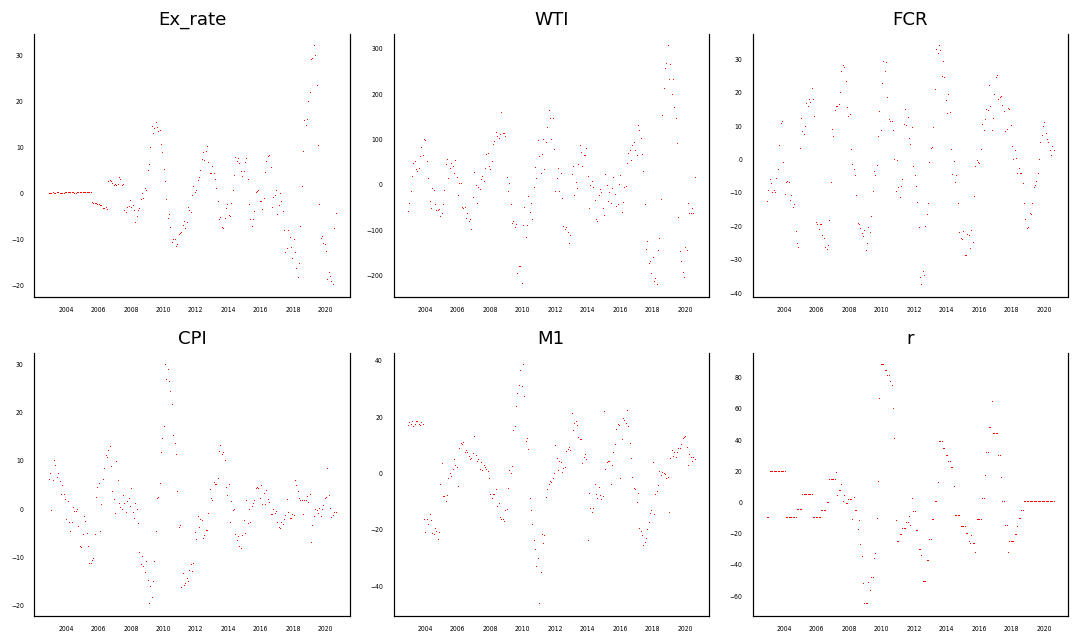

In [6]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=3, dpi=109, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]] #Esto es para que los títulos tengan los mismos nombres que los cabezales
    ax.plot(data, ',', color='red', linewidth=99)
 # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=4)
    
plt.tight_layout()
plt.show()

In [7]:
import numpy as np
#6. Testing Causation using Granger’s Causality Test
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=14
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df
    
grangers_causation_matrix(df, variables = df.columns)

,Ex_rate_x,WTI_x,FCR_x,CPI_x,M1_x,r_x
Ex_rate_y,1.0000,0.0002,0.0007,0.0003,0.0012,0.0017
WTI_y,0.0002,1.0000,0.0010,0.0006,0.0041,0.0484
FCR_y,0.1038,0.0002,1.0000,0.0001,0.0000,0.0010
CPI_y,0.0078,0.0000,0.0000,1.0000,0.0000,0.0000
M1_y,0.0000,0.0001,0.0000,0.0000,1.0000,0.0000
r_y,0.0002,0.0017,0.0008,0.0003,0.0000,1.0000


In [9]:
#Es muy interesante esto que hemos encontrado de las endógenas y exógenas
#Tal vez deberiamos incluir WTI en el grupo de endógenas
#saber como se pone la frecuencia queda pendiente
from statsmodels.tsa.api import VAR
import statsmodels.api as sm
model = VAR(endog=df[['Ex_rate','WTI']],exog=df[['FCR','WTI']],freq=None)

C:\Users\Edu\anaconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [10]:
#fit([maxlags, method, ic, trend, verbose])
results = model.fit(maxlags=None,method='ols',ic='hqic',trend='nc',verbose=True)
results.summary()

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 3, BIC -> 3, FPE -> 3, HQIC -> 3>
Using 3 based on hqic criterion


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 15, Oct, 2020
Time:                     16:48:01
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -57.8971
Nobs:                     210.000    HQIC:                  -58.0490
Log likelihood:           5526.01    FPE:                5.55787e-26
AIC:                     -58.1521    Det(Omega_mle):     5.15744e-26
--------------------------------------------------------------------
Results for equation Ex_rate
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
FCR               -0.032881         0.010537           -3.121           0.002
WTI                0.019209         0.003897            4.929           0.000
L1.Ex_rate         1.298446         0.070890           18.316         

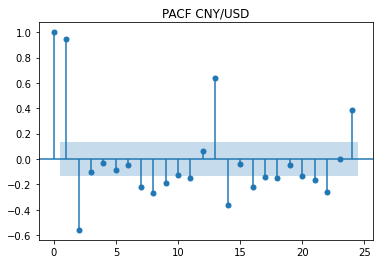

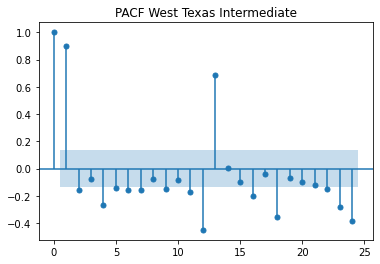

In [11]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(df['Ex_rate'],title='PACF CNY/USD')
plot_pacf(df['WTI'],title='PACF West Texas Intermediate')

plt.show()

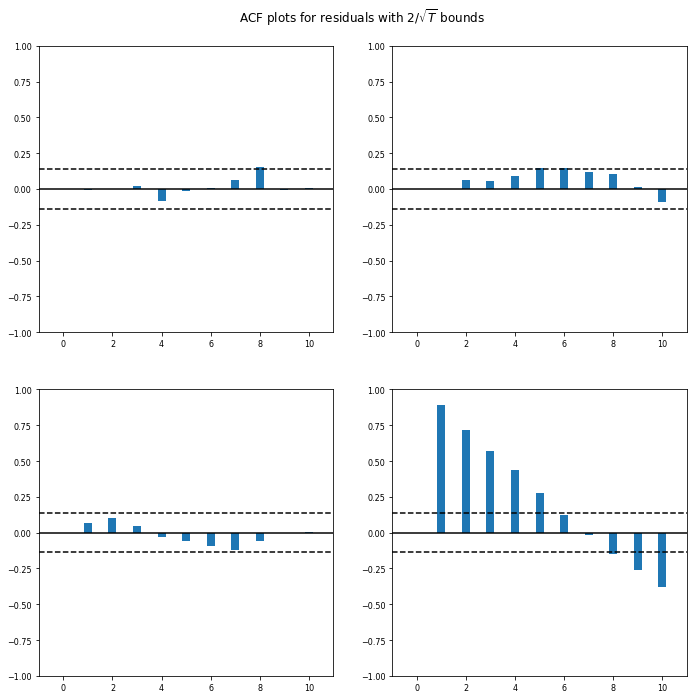

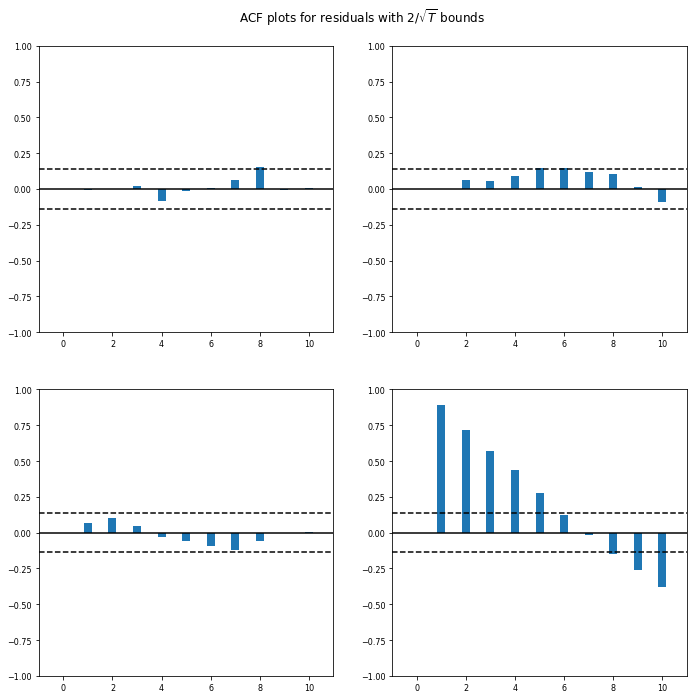

In [12]:
results.plot_acorr()

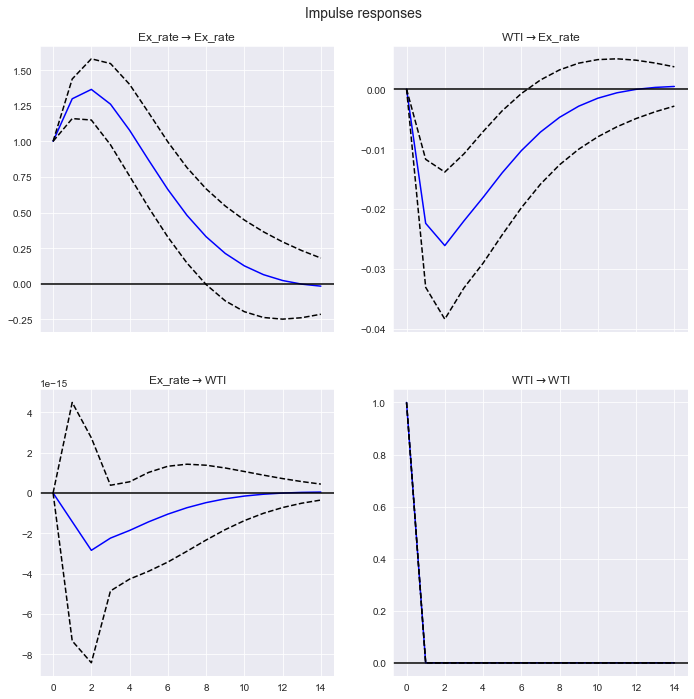

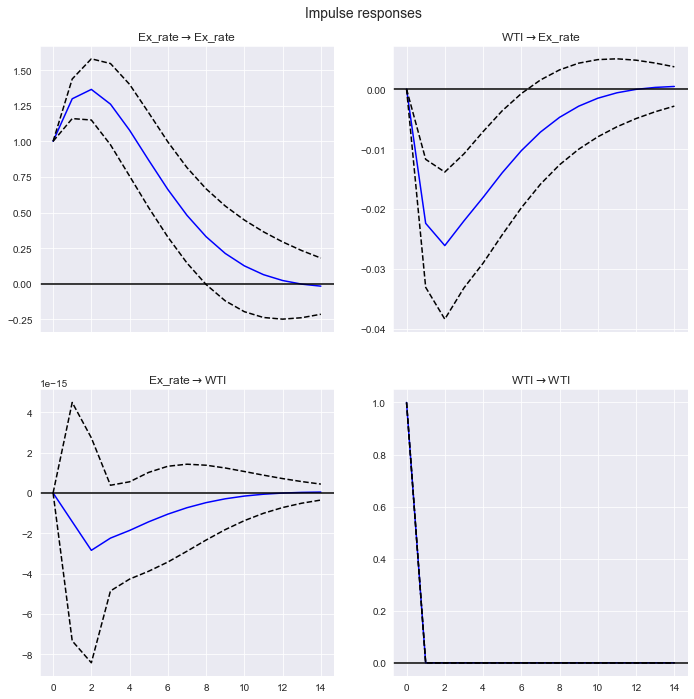

In [10]:
#Esto es simplemente para que el estilo del gráfico sea seaborn ( esto le dará uniformidad al paper)
import seaborn as sns
sns.set_style("darkgrid")
irf = results.irf(14)
irf.plot(orth=False)

In [11]:
estabilidad = results.is_stable(verbose=bool)
estabilidad

Eigenvalues of VAR(1) rep
0.7503155000753813
0.7503155000753813
0.1648553310002986
9.30752403425999e-06
9.30752403425999e-06
9.30754085434559e-06


True

In [12]:
autocorrelation = results.resid_acorr(nlags=5)
autocorrelation

array([[[ 1.        ,  0.00198304],
        [ 0.00198304,  1.        ]],

       [[-0.00844784, -0.003301  ],
        [ 0.0644835 ,  0.88971143]],

       [[-0.00155201,  0.06121078],
        [ 0.09952228,  0.71376437]],

       [[ 0.02391694,  0.0570114 ],
        [ 0.04517867,  0.57304567]],

       [[-0.0846918 ,  0.09103605],
        [-0.02736611,  0.43571282]],

       [[-0.01077873,  0.14454644],
        [-0.06056903,  0.27810222]]])

In [13]:
#H0 (null) : data are generated by a Gaussian-distributed process [Jarque-Bera-style]
normalidad = results.test_normality(signif=0.10)
normalidad.summary()

Test statistic,Critical value,p-value,df
54.26,7.779,0.000,4


In [14]:
autocorr2 = results.test_whiteness(nlags=6, signif=0.05, adjusted=True)
autocorr2.summary()

Test statistic,Critical value,p-value,df
425.9,21.03,0.000,12
